In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 100


import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000  #as we dealing with bigdataset it helps to divide into chunks

#Preprocessing Lib
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV

#Metrics
from sklearn import metrics

#featureEngineering
from sklearn.decomposition import PCA


#model_selection
from sklearn.model_selection import train_test_split

#models
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression,Lasso,Ridge

from tqdm.notebook import tqdm


In [2]:
df = pd.read_csv('true_car_listings.csv')

In [3]:
df.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852122 entries, 0 to 852121
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    852122 non-null  int64 
 1   Year     852122 non-null  int64 
 2   Mileage  852122 non-null  int64 
 3   City     852122 non-null  object
 4   State    852122 non-null  object
 5   Vin      852122 non-null  object
 6   Make     852122 non-null  object
 7   Model    852122 non-null  object
dtypes: int64(3), object(5)
memory usage: 52.0+ MB


Смотрим пропуски

In [5]:
df.isnull().sum()

Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

Отлично, пропусков нет

Посмотрим распределения, но, как мы видим, у нас только 3 численных переменных(Price, Year, Mileage), остальные категориальные.<br>
для них нет смысла что-то нормаровать и тд, так что мы их трогать не будем.

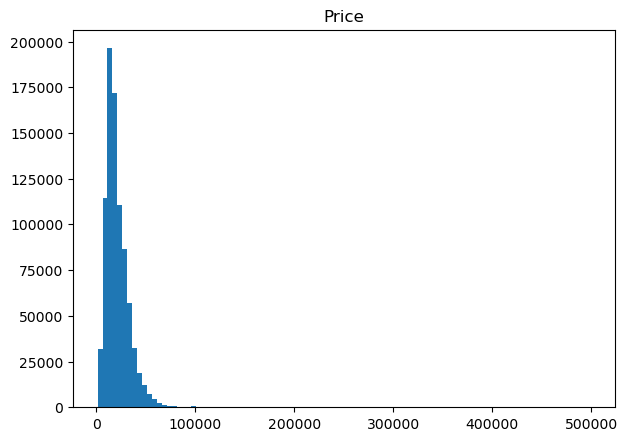

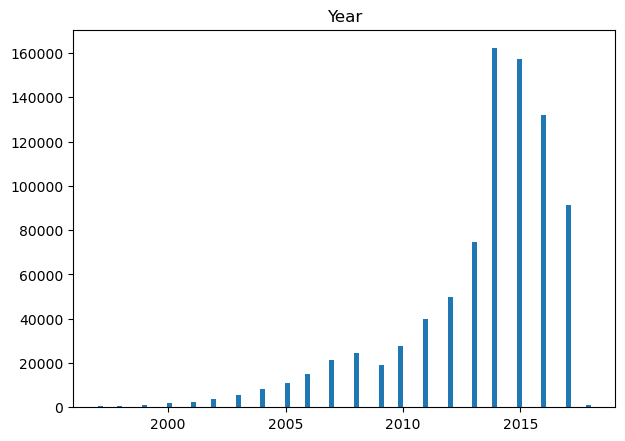

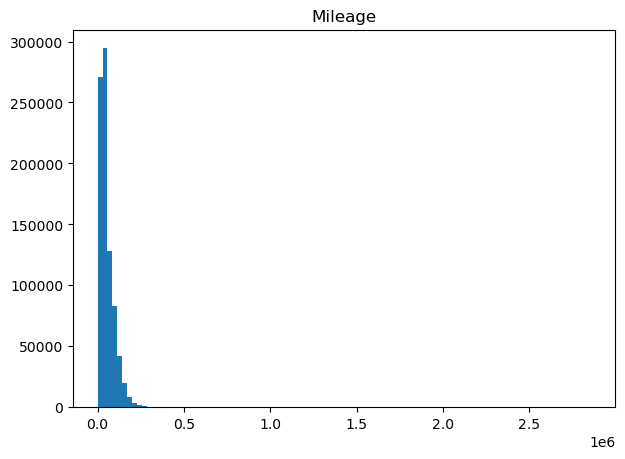

In [6]:
for column in ['Price', 'Year', 'Mileage']:
    plt.hist(df[column], bins=100)
    plt.title(column)
    plt.show()

Это гистограммы распределения численных признаков, как мы видим, у Price и Mileage есть гигантские выбросы. Давайте их ображем.
Так как эти выбросы справа, давайте просто найдем 95 квантиль и по нему обрежем.

In [7]:
quantiles = {}
for i in ['Price','Mileage']:
    quantiles[i] = df[i].quantile(0.95)
quantiles

{'Price': 43300.0, 'Mileage': 134299.0}

Квантили нашли. Обрезаем:

Количесво элементов, после удаления выбросов: 766936


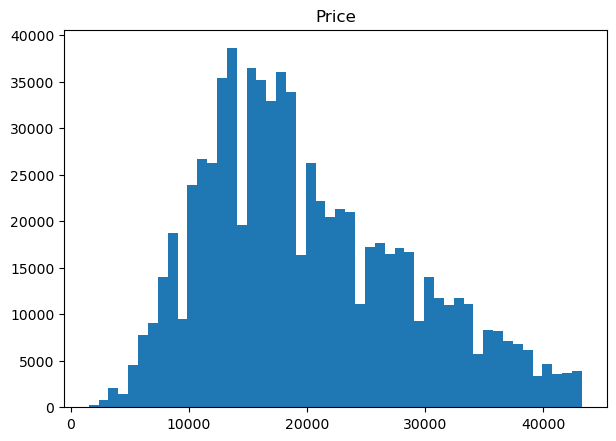

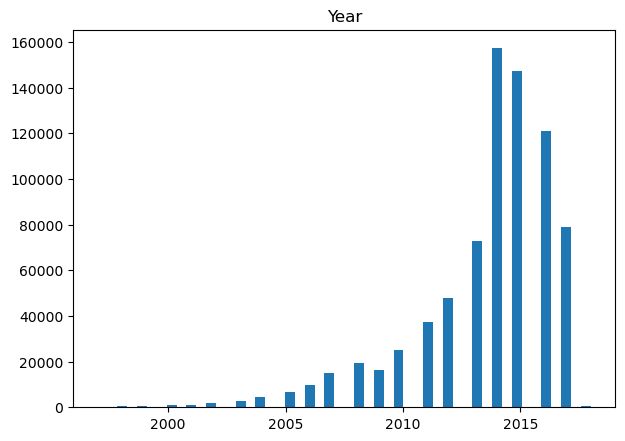

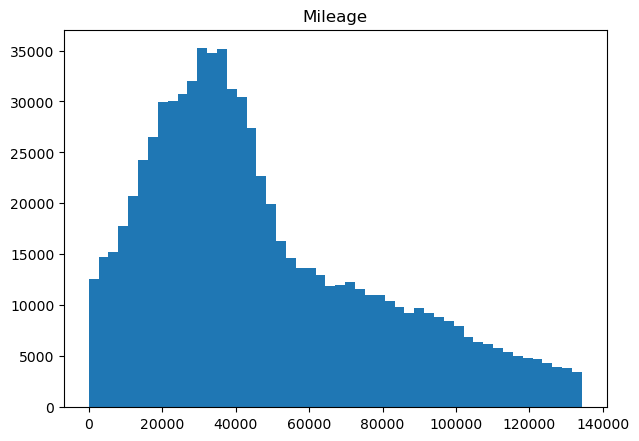

In [8]:
df_jew = df[(df['Price'] < quantiles['Price']) & (df['Mileage'] < quantiles['Mileage'])]
print(f'Количесво элементов, после удаления выбросов: {df_jew.count().values[0]}')
for column in ['Price', 'Year', 'Mileage']:
    plt.hist(df_jew[column], bins=50)
    plt.title(column)
    plt.show()

Это снова гистограммы численных признаков

In [9]:
print(f'Сколько данных мы потеряли: {1 - df_jew.count().values[0]/df.count().values[0]}')

Сколько данных мы потеряли: 0.09996925322899775


Ну во, потеряли всего 10% при этом все ствло сильно лучше. Осталось привести к нормальному виду.<br>
Только перед этим давайте разберемся с категориальными значениями. и дропнем vin, т.к. он уникален для каждой машины.

In [10]:
df_jew.head()

,Price,Year,Mileage,City,State,Vin,Make,Model
0,8995,2014,35725,El Paso,TX,19VDE2E53EE000083,Acura,ILX6-Speed
1,10888,2013,19606,Long Island City,NY,19VDE1F52DE012636,Acura,ILX5-Speed
2,8995,2013,48851,El Paso,TX,19VDE2E52DE000025,Acura,ILX6-Speed
3,10999,2014,39922,Windsor,CO,19VDE1F71EE003817,Acura,ILX5-Speed
4,14799,2016,22142,Lindon,UT,19UDE2F32GA001284,Acura,ILXAutomatic


In [11]:
df_jew.drop('Vin', axis=1, inplace=True)

C:\Users\Dima\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
for column in df_jew.columns:
    if df_jew[column].dtype == 'object':
        le = LabelEncoder()
        df_jew[column] = le.fit_transform(df_jew[column])
        print(f'{column}: {df_jew[column].nunique()}')
df_jew.head()

<ipython-input-12-48fc03e15da9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jew[column] = le.fit_transform(df_jew[column])


City: 2552
State: 59
Make: 53
Model: 2425


,Price,Year,Mileage,City,State,Make,Model
0,8995,2014,35725,646,49,1,1037
1,10888,2013,19606,1259,39,1,1036
2,8995,2013,48851,646,49,1,1037
3,10999,2014,39922,2489,6,1,1036
4,14799,2016,22142,1230,50,1,1039


Хочу перед тем как начать нормировать посмотреть на корреляцию

<AxesSubplot:>

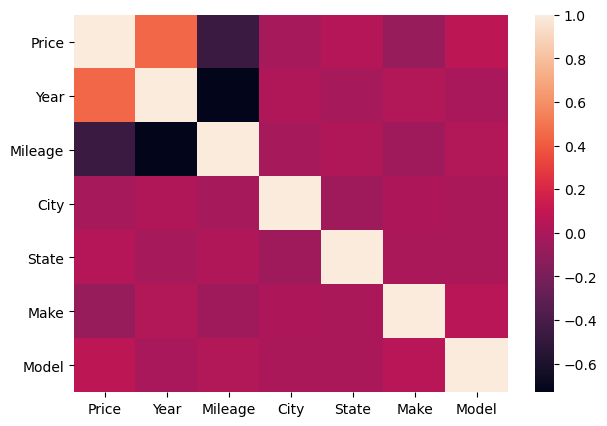

In [13]:
sns.heatmap(df_jew.corr())

корреляция Year-Price и Mileage-Price - нас не смущает, но наличие корреляции между признаками Mileage-Year - не очень хорошо. Давайте посмотрим, насколько там все линейно.

In [14]:
_, sing, _ = np.linalg.svd(df_jew[['Price', 'Year', 'Mileage']].head(5000))
sing

array([4620311.03673719,  998240.2330615 ,   18526.59161303])

In [15]:
_, sing, _ = np.linalg.svd(df_jew.head(5000))
sing

array([4.62221852e+06, 1.00064037e+06, 5.46165455e+04, 2.58041959e+04,
       1.64416119e+04, 1.19603877e+03, 5.42779990e-02])

Отсутсвие нулевых сингулярных чисел, разрешает нам, на мой вкус, принять эвристику, что в данных нет сильной линейной зависимости (будем число неотличимым от машинного нуля при 10**-9)

<h3>Наш дальнейший план:</h3>
1) Построить модельки без приведения к нормальному виду и нормализации. <b>++++</b><br>
2) Построить модельки с приведением к нормальному виду и нормализацией. <b>++++</b> <br>

In [16]:
xtrain, xtest, ytrain, ytest = train_test_split(df_jew.drop('Price', axis=1), df_jew.Price, test_size=0.2, random_state=42)

In [17]:
%%time
model = LinearRegression()
print(model)
cross_score = cross_val_score(model, xtrain, ytrain)
print(f'cross val score mean: {cross_score.mean()}')
model.fit(xtrain, ytrain)
print(f'test score: {model.score(xtest, ytest)}')

LinearRegression()
cross val score mean: 0.2630339720491948
test score: 0.2642563239730833
Wall time: 469 ms


In [18]:
%%time
model = XGBRegressor(n_jobs=-1)
print(model)
cross_score = cross_val_score(model, xtrain, ytrain, n_jobs=-1)
print(f'cross val score mean: {cross_score.mean()}')
model.fit(xtrain, ytrain)
print(f'test score: {model.score(xtest, ytest)}')

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
cross val score mean: 0.882158186610206
test score: 0.8840723905402464
Wall time: 39 s


Если что мы работаем с метрикой <b>R^2</b>, https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination<br>
Чем она ближе к 1, тем лучше. Давайте поподбираем параметры.

Давайте нашу тренировочную выборку разделим на две, тренировчную и валидационную, что бы было можно было потом посмотреть, на чистых данных наш результат.

In [19]:
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

Давайте посмотрим на точности от количества деревьев и их глибины в бустинге.

In [20]:
%%time
scores_rf = pd.DataFrame({'estimators':[], 'depth': [], 'score_r2': []})
for depth in range(1,11):
    for estimators in [10,50,100]:
        model = XGBRegressor(n_jobs=-1, n_estimators=estimators, max_depth=depth)
        model.fit(xtrain1, ytrain1)
        score = model.score(xtest1, ytest1)
        print(f'model: XGBRegressor; estimators: {estimators}; depth: {depth}; Test score: {score}')
        scores_rf = scores_rf.append({'estimators':estimators, 'depth': depth, 'score_r2': score}, ignore_index=True)

model: XGBRegressor; estimators: 10; depth: 1; Test score: 0.24900968239344035
model: XGBRegressor; estimators: 50; depth: 1; Test score: 0.35494776775425974
model: XGBRegressor; estimators: 100; depth: 1; Test score: 0.40342352735438836
model: XGBRegressor; estimators: 10; depth: 2; Test score: 0.34157343154323727
model: XGBRegressor; estimators: 50; depth: 2; Test score: 0.6104970118461523
model: XGBRegressor; estimators: 100; depth: 2; Test score: 0.6930220067571669
model: XGBRegressor; estimators: 10; depth: 3; Test score: 0.45471524169152466
model: XGBRegressor; estimators: 50; depth: 3; Test score: 0.7252711505644227
model: XGBRegressor; estimators: 100; depth: 3; Test score: 0.796103771264042
model: XGBRegressor; estimators: 10; depth: 4; Test score: 0.49811568673710593
model: XGBRegressor; estimators: 50; depth: 4; Test score: 0.7842097817647546
model: XGBRegressor; estimators: 100; depth: 4; Test score: 0.8390953767014148
model: XGBRegressor; estimators: 10; depth: 5; Test sco

In [21]:
print(scores_rf.groupby(['depth']).min())
print(scores_rf.groupby(['depth']).max())

       estimators  score_r2
depth                      
1.0          10.0  0.249010
2.0          10.0  0.341573
3.0          10.0  0.454715
4.0          10.0  0.498116
5.0          10.0  0.587676
6.0          10.0  0.670211
7.0          10.0  0.712779
8.0          10.0  0.775408
9.0          10.0  0.807597
10.0         10.0  0.835044
       estimators  score_r2
depth                      
1.0         100.0  0.403424
2.0         100.0  0.693022
3.0         100.0  0.796104
4.0         100.0  0.839095
5.0         100.0  0.867062
6.0         100.0  0.880642
7.0         100.0  0.892817
8.0         100.0  0.899298
9.0         100.0  0.902537
10.0        100.0  0.905839


как мы видим ту влияют и глубина и количество деревьев

Давайте тогда возьмем какое-нибудь большое число деревьев и не будем ограничевать глубину.

In [22]:
%%time
n_estimators = 1000
model = XGBRegressor(n_jobs=-1, n_estimators=n_estimators)
model.fit(xtrain1, ytrain1)
train_score = model.score(xtrain1, ytrain1)
valid_score = model.score(xtest1, ytest1)
test_score = model.score(xtest, ytest)
print(f'model: XGBRegressor; estimators: {n_estimators}; Train score: {train_score}; Valid score: {valid_score}; Test score: {score}')

model: XGBRegressor; estimators: 1000; Train score: 0.930178830783998; Valid score: 0.9104515620108564; Test score: 0.9058388160490289
Wall time: 1min 38s


как мы видим, небольшое переобучение присутсвует, но результат не плох. и он точно лучше чем при меньшем количестве деревьев.

In [23]:
df_result = pd.DataFrame({'pred': model.predict(xtest), 'true': ytest})
df_result = df_result.sort_values('true').reset_index()
df_result['diff'] = df_result.pred - df_result.true

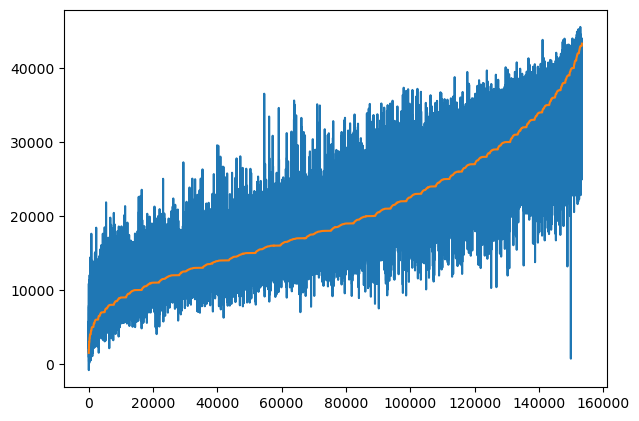

In [24]:
plt.plot(df_result.index, df_result.pred)
plt.plot(df_result.index, df_result.true)

<em> это ответы на нашей тестовой выборке, оранжевые - реальные, синие - предсказанные </em>

выглядит это конечно не столь радостно, как выглядел результат, но как минимум, оно явно угадывает тенденцию.

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 9.0000e+00, 1.8000e+01, 3.3000e+01, 4.0000e+01,
        5.5000e+01, 8.2000e+01, 1.2900e+02, 1.9000e+02, 2.8000e+02,
        5.2100e+02, 9.6100e+02, 1.7800e+03, 3.0830e+03, 5.9740e+03,
        1.2165e+04, 2.3962e+04, 3.9236e+04, 3.3829e+04, 1.7429e+04,
        7.4120e+03, 3.1960e+03, 1.4590e+03, 7.2400e+02, 3.7000e+02,
        1.9200e+02, 1.0600e+02, 6.2000e+01, 4.0000e+01, 2.7000e+01,
        8.0000e+00, 4.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-39073.473  , -37875.08   , -36676.684  , -35478.29   ,
        -34279.895  , -33081.5    , -31883.104  , -30684.709  ,
        -29486.312  , -28287.918  , -27089.523  , -25891.129  ,
        -24692.734  , -23494.338  , -22295.943  , -21097.549  ,
        -19899.154  , -18700.76   , -17502.363  , -16303.969  

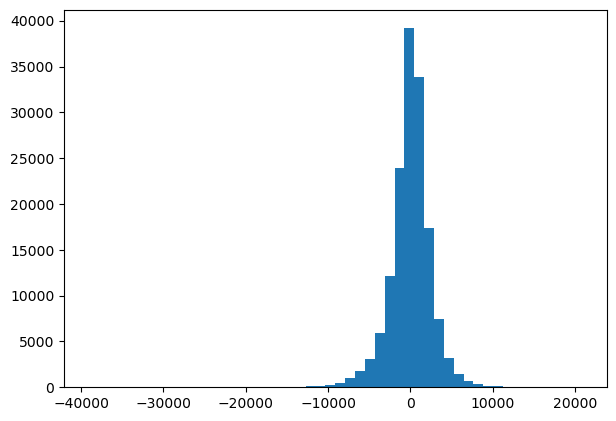

In [25]:
plt.hist(df_result['diff'], bins=50)

In [26]:
df_result['diff'].mean(), df_result['diff'].std()

(7.166159629821777, 2548.87109375)

### Пока можно сказать, что, результаты не плохи, но дисперсия великовата. Давайте повторим наши изыскания для данных приведенных к нормальному виду.







In [27]:
from sklearn.preprocessing import PowerTransformer

In [28]:
df_new_jew = df_jew.copy()

In [29]:
for column in ['Year', 'Mileage']:
    df_new_jew[column] = PowerTransformer().fit_transform(np.log(np.array(df_jew[column]).reshape(-1, 1)))

C:\Users\Dima\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2960: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
C:\Users\Dima\anaconda3\lib\site-packages\numpy\core\_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Dima\anaconda3\lib\site-packages\numpy\core\_methods.py:246: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Year. Mean: -9.603356608872716e-14, Std: 1.0000006519491753


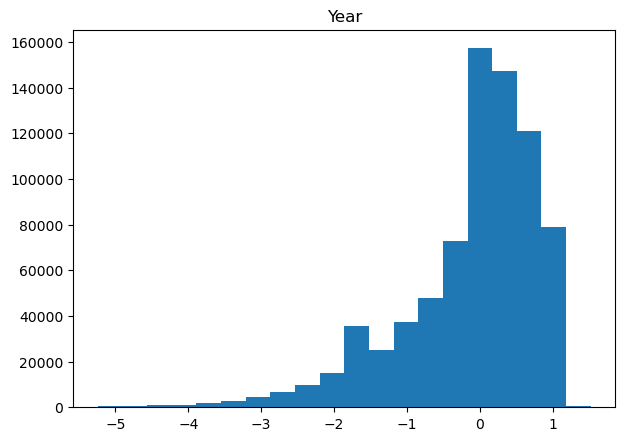

Mileage. Mean: -7.730952860487248e-16, Std: 1.0000006519455211


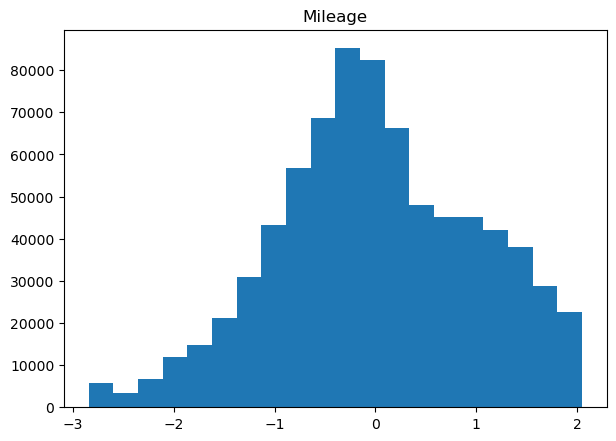

In [30]:
for column in ['Year', 'Mileage']:
    print(f'{column}. Mean: {df_new_jew[column].mean()}, Std: {df_new_jew[column].std()}')
    plt.hist(df_new_jew[column], bins=20)
    plt.title(column)
    plt.show()

Прикроем глаза и будем считать, что они нормально распределены + среднее 0 и дисперсия 1.

Price. Mean: 1.35929650573019e-15, Std: 1.0000006519453053


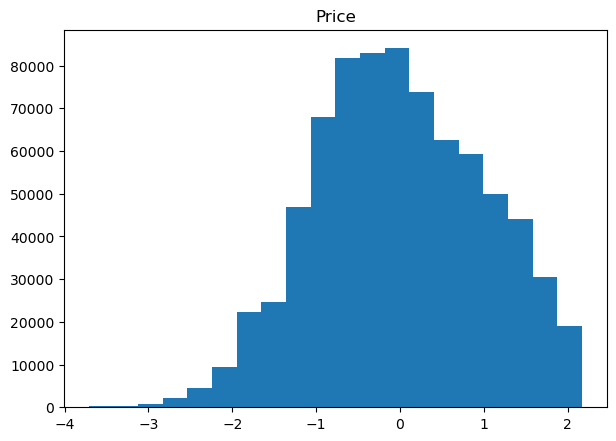

In [31]:
column = 'Price'
price_transform = PowerTransformer()
df_new_jew[column] = price_transform.fit_transform(np.array(df_jew[column]).reshape(-1, 1))
print(f'{column}. Mean: {df_new_jew[column].mean()}, Std: {df_new_jew[column].std()}')
plt.hist(df_new_jew[column], bins=20)
plt.title(column)
plt.show()

Сойдет

In [32]:
xtrain, xtest, ytrain, ytest = train_test_split(df_new_jew.drop('Price', axis=1), df_new_jew.Price, test_size=0.2, random_state=42)
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(xtrain, ytrain, test_size=0.2, random_state=42)

In [33]:
%%time
scores_rf = pd.DataFrame({'estimators':[], 'depth': [], 'score_r2': []})
for depth in range(1,11):
    for estimators in [10,50,100]:
        model = XGBRegressor(n_jobs=-1, n_estimators=estimators, max_depth=depth)
        model.fit(xtrain1, ytrain1)
        score = model.score(xtest1, ytest1)
        print(f'model: XGBRegressor; estimators: {estimators}; depth: {depth}; Test score: {score}')
        scores_rf = scores_rf.append({'estimators':estimators, 'depth': depth, 'score_r2': score}, ignore_index=True)

model: XGBRegressor; estimators: 10; depth: 1; Test score: 0.29297538399174505
model: XGBRegressor; estimators: 50; depth: 1; Test score: 0.39488756183791973
model: XGBRegressor; estimators: 100; depth: 1; Test score: 0.441306535544684
model: XGBRegressor; estimators: 10; depth: 2; Test score: 0.3688487762622886
model: XGBRegressor; estimators: 50; depth: 2; Test score: 0.6381873614760893
model: XGBRegressor; estimators: 100; depth: 2; Test score: 0.7204597898085217
model: XGBRegressor; estimators: 10; depth: 3; Test score: 0.4298900942215754
model: XGBRegressor; estimators: 50; depth: 3; Test score: 0.7379109970512129
model: XGBRegressor; estimators: 100; depth: 3; Test score: 0.808075189595676
model: XGBRegressor; estimators: 10; depth: 4; Test score: 0.5507736528962976
model: XGBRegressor; estimators: 50; depth: 4; Test score: 0.8058806182083801
model: XGBRegressor; estimators: 100; depth: 4; Test score: 0.854286242970308
model: XGBRegressor; estimators: 10; depth: 5; Test score: 0.

Видно, что стало немного получше.

In [34]:
%%time
n_estimators = 1000
model = XGBRegressor(n_jobs=-1, n_estimators=n_estimators)
model.fit(xtrain1, ytrain1)
train_score = model.score(xtrain1, ytrain1)
valid_score = model.score(xtest1, ytest1)
test_score = model.score(xtest, ytest)
print(f'model: XGBRegressor; estimators: {n_estimators}; Train score: {train_score}; Valid score: {valid_score}; Test score: {score}')

model: XGBRegressor; estimators: 1000; Train score: 0.9381026106577484; Valid score: 0.9204023531693403; Test score: 0.914121318876946
Wall time: 1min 37s


In [35]:
df_result = pd.DataFrame({'pred': model.predict(xtest), 'true': ytest})
df_result = df_result.sort_values('true').reset_index()
df_result['diff'] = df_result.pred - df_result.true

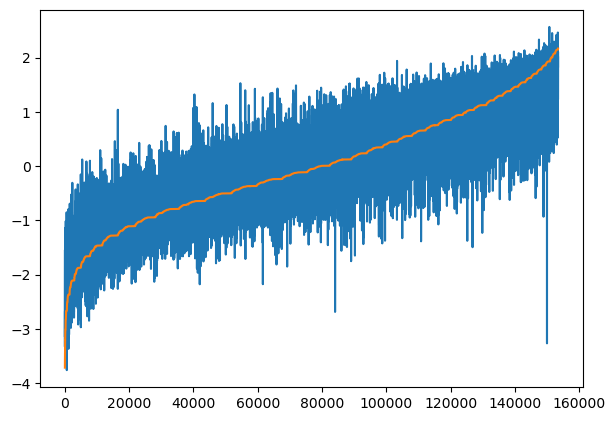

In [36]:
plt.plot(df_result.index, df_result.pred)
plt.plot(df_result.index, df_result.true)

In [37]:
df_result['diff'].mean(), df_result['diff'].std()

(0.000970996858266075, 0.2790059562486198)

### На тестовой выборке R<sup>2</sup> конечно улучшилась на 0.01, что не очень много, но все равно приятно.